In [1]:
import os
import pandas as pd
import json
import numpy as np
import matplotlib.pyplot as plt
import math
from IPython.display import clear_output
import seaborn as sns
import math
from collections import Counter
from scipy import stats

### Main

In [2]:
action_legends = [
    'Drop Home Pheromone', 
    'Drop Food Pheromone', 
    'Follow Home Pheromone', 
    'Follow Food Pheromone',
    'Move Randomly'
]

In [3]:
root = '../data/'
folders = os.listdir(root)

index = 2

folder = folders[index]
folder_path = root + folder + '/'

### Read Data

In [4]:
def read_params_data(folder_path):
    file_path = folder_path + 'params.json'
    with open(file_path) as readFile:
        return json.load(readFile)

In [5]:
def read_agents_data(folder_path, num_agents):
    agents_data = {}
    for ant in range(1, num_agents+1):
        agents_data[ant] = pd.read_pickle(folder_path + 'agent_' + str(ant) + '.pkl')    
    return agents_data

In [6]:
simulation_data = {}
simulation_data['params'] = read_params_data(folder_path)

In [7]:
bin_size = 5000
antCount = simulation_data['params']['antCount']
actions = simulation_data['params']['actions']
stepsCount = simulation_data['params']['stepsCount']
num_bins = math.ceil(stepsCount / bin_size)

In [8]:
simulation_data['agents'] = read_agents_data(folder_path, antCount)

### Bin Data

In [9]:
def generate_chunks(seq, size):
    for pos in range(0, len(seq), size):
        yield seq.iloc[pos:pos+size]

In [10]:
def create_binned_actions(agent_df, actions, bin_size, num_bins):
    actions_df = agent_df.filter(['action'])

    binned_actions = {}
    for i in actions:
        binned_actions[i] = []
    
    for chunk in generate_chunks(actions_df, bin_size):
        action_count = chunk['action'].value_counts()
    
        for action in actions:
            try:
                binned_actions[action].append(action_count[action])
            except:
                binned_actions[action].append(0)
    
    for action in actions:
        binned_actions[i] = np.array(binned_actions[i])
    
    return binned_actions

In [11]:
def create_binned_trips(agent_df, bin_size, num_bins):
    trips_df = agent_df.filter(['tripCompleted'])
    
    binned_trips = []

    for chunk in generate_chunks(trips_df, bin_size):
        trips_count = chunk['tripCompleted'].value_counts()
    
        try:
            binned_trips.append(trips_count[1])
        except:
            binned_trips.append(0)
    
    return np.array(binned_trips)

In [12]:
simulation_data['binned_actions'] = {}
simulation_data['binned_trips'] = {}
simulation_data['binned_epsilon'] = {}

for ant in range(1, antCount+1):
    simulation_data['binned_actions'][ant] = create_binned_actions(simulation_data['agents'][ant], actions, bin_size, num_bins)
    simulation_data['binned_trips'][ant] = create_binned_trips(simulation_data['agents'][ant], bin_size, num_bins)

In [13]:
simulation_data['total_binned_actions'] = {}

for action in actions:
    simulation_data['total_binned_actions'][action] = np.zeros(num_bins)

simulation_data['total_binned_trips'] = np.zeros(num_bins)

In [14]:
for ant in range(1, antCount+1):
    for action in actions:
        simulation_data['total_binned_actions'][action] += simulation_data['binned_actions'][ant][action]
        simulation_data['total_binned_trips'] += simulation_data['binned_trips'][ant]

### Create Plots

In [15]:
# def create_plot(binned_actions, binned_trips, actions, agent):
#     fig, axes = plt.subplots(2, 1, figsize = (10,10))

#     x = np.array(range( len(binned_trips) )) * bin_size
#     y_actions = []
#     for action in actions:
#         y_actions.append( binned_actions[action] )

#     axes[0].stackplot(x, y_actions, labels = action_legends)
#     axes[0].title.set_text('Actions of agent '+str(agent))
#     axes[0].legend(loc='upper left')

#     y_trips = binned_trips
    
#     axes[1].plot(x, y_trips, label ='Successful trips per agent for ' +str(bin_size)+ ' time steps')
#     axes[1].title.set_text('Successful trips of agent '+str(agent))
#     axes[1].legend(loc='upper left')
    
# #     fig.tight_layout()
# #     fig.savefig(root + folder + '/' +folder+ '_agent_' + str(agent) + '.jpg', bbox_inches='tight', dpi=250)

In [16]:
# for ant in range(1, antCount+1):
#     create_plot(
#         simulation_data['binned_actions'][ant], 
#         simulation_data['binned_trips'][ant], 
#         actions, 
#         ant
#     )

# create_plot(
#     simulation_data['total_binned_actions'], 
#     simulation_data['total_binned_trips'], 
#     actions, 
#     'total'
# )

# clear_output()

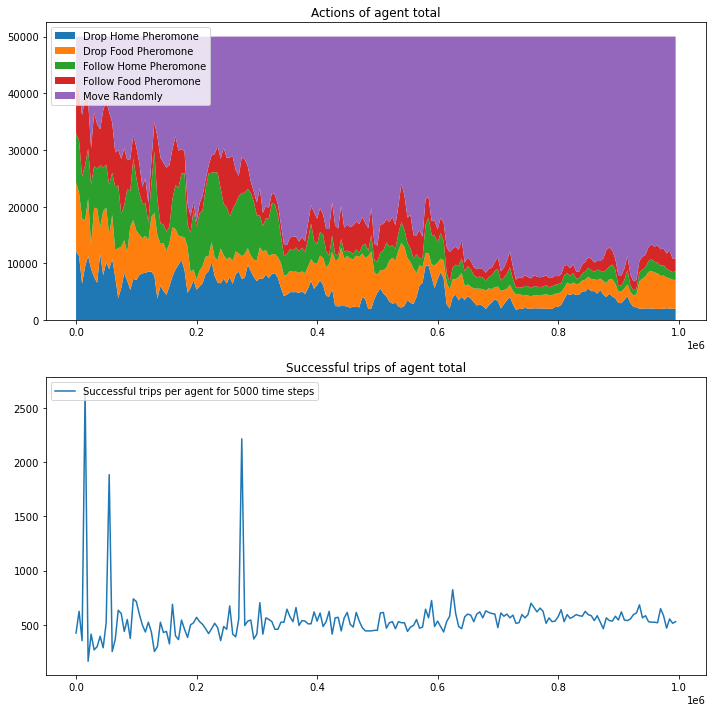

In [17]:
binned_actions = simulation_data['total_binned_actions']
binned_trips = simulation_data['total_binned_trips']
agent = 'total'

fig, axes = plt.subplots(2, 1, figsize = (10,10))

x = np.array(range( len(binned_trips) )) * bin_size
y_actions = []
for action in actions:
    y_actions.append( binned_actions[action] )

axes[0].stackplot(x, y_actions, labels = action_legends)
axes[0].title.set_text('Actions of agent '+str(agent))
axes[0].legend(loc='upper left')

y_trips = binned_trips

axes[1].plot(x, y_trips, label ='Successful trips per agent for ' +str(bin_size)+ ' time steps')
axes[1].title.set_text('Successful trips of agent '+str(agent))
axes[1].legend(loc='upper left')

fig.tight_layout()

In [18]:
simulation_data['params']['version']

'Condition 1'

### Pair Plots

In [19]:
# def create_pair_plots(simulation_data):
#     df = pd.DataFrame({
#         'trips': simulation_data['total_binned_trips'],
#         'Drop Home Pheromone': simulation_data['total_binned_actions'][0],
#         'Drop Food Pheromone': simulation_data['total_binned_actions'][1],
#         'Follow Home Pheromone': simulation_data['total_binned_actions'][2],
#         'Follow Food Pheromone': simulation_data['total_binned_actions'][3],
#         'Move Randomly': simulation_data['total_binned_actions'][4],
#     })
    
#     fig = plt.figure()
    
#     sns.set_theme(style="ticks")
#     sns_plot = sns.pairplot(df, corner=False, kind='kde')
    
#     sns_plot.savefig(root + folder + '/' +folder+ '_pairplot.jpg', bbox_inches='tight', dpi=250)

<Figure size 432x288 with 0 Axes>

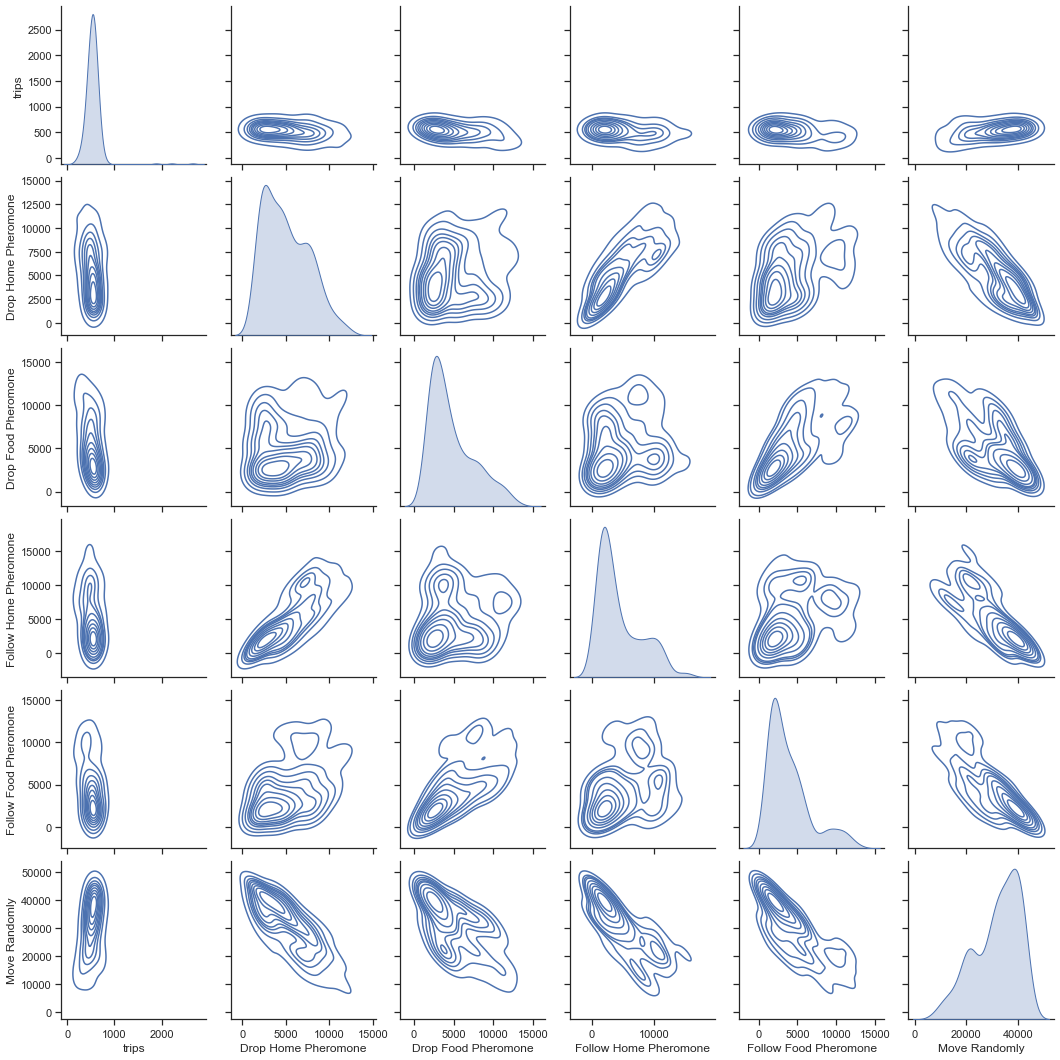

In [20]:
# create_pair_plots(simulation_data)
# # clear_output()

<Figure size 432x288 with 0 Axes>

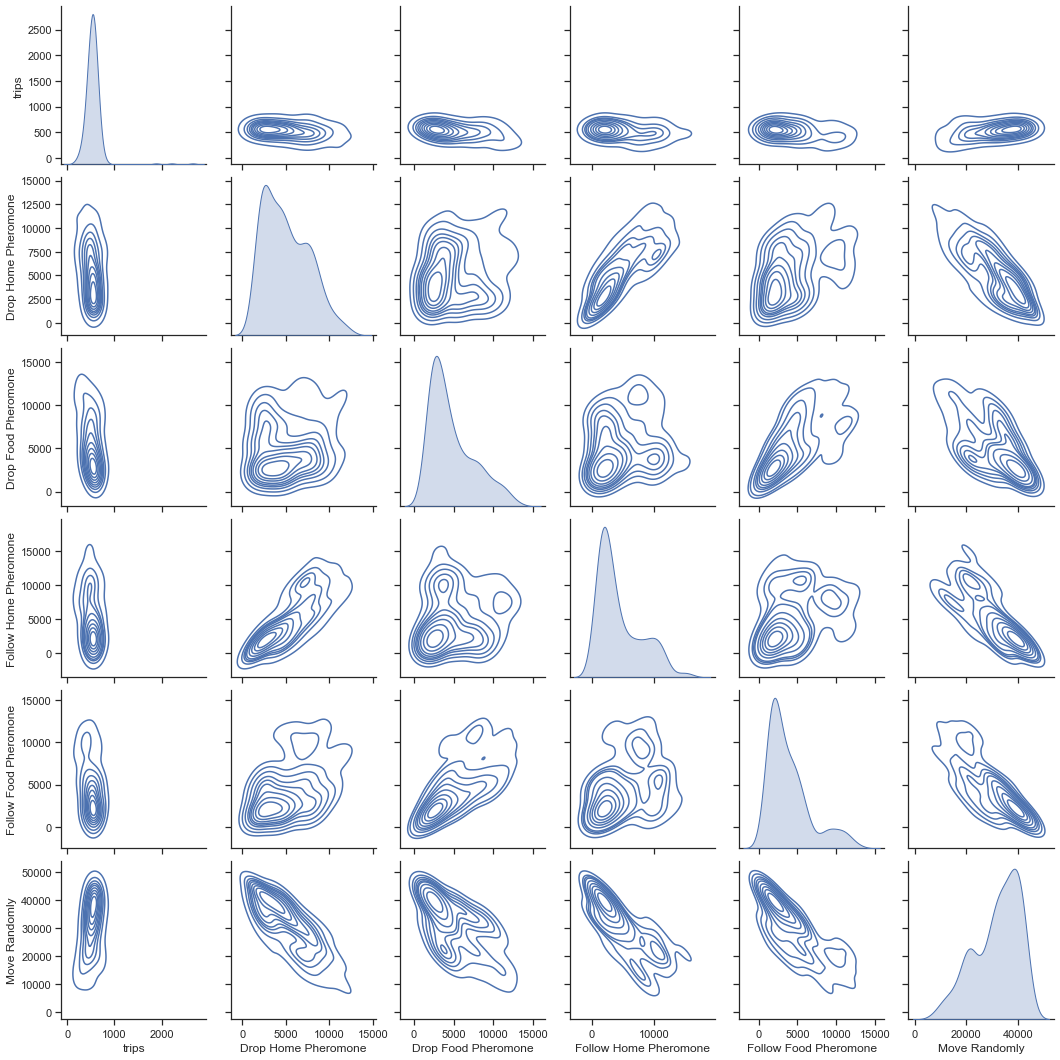

In [34]:
df = pd.DataFrame({
    'trips': simulation_data['total_binned_trips'],
    'Drop Home Pheromone': simulation_data['total_binned_actions'][0],
    'Drop Food Pheromone': simulation_data['total_binned_actions'][1],
    'Follow Home Pheromone': simulation_data['total_binned_actions'][2],
    'Follow Food Pheromone': simulation_data['total_binned_actions'][3],
    'Move Randomly': simulation_data['total_binned_actions'][4],
})

fig = plt.figure()

sns.set_theme(style="ticks")
sns_plot = sns.pairplot(df, corner=False, kind='kde')

### Pearson Correlation Coeffecient

In [21]:
def pearson_correlation(independent, dependent):
    # covariance
    independent_mean = _arithmetic_mean(independent)
    dependent_mean = _arithmetic_mean(dependent)
    products_mean = _mean_of_products(independent, dependent)
    covariance = products_mean - (independent_mean * dependent_mean)

    # standard deviations of independent values
    independent_standard_deviation = _standard_deviation(independent)

    # standard deviations of dependent values
    dependent_standard_deviation = _standard_deviation(dependent)

    # Pearson Correlation Coefficient
    rho = covariance / (independent_standard_deviation * dependent_standard_deviation)

    return rho

def  _arithmetic_mean(data):
    total = 0
    for i in data:
        total+= float(i)
    return total / len(data)

def  _mean_of_products(data1, data2):
    total = 0
    for i in range(0, len(data1)):
        total += (data1[i] * data2[i])
    return total / len(data1)

def  _standard_deviation(data):
    squares = []

    for i in data:
        squares.append(i ** 2)

    mean_of_squares = _arithmetic_mean(squares)
    mean_of_data = _arithmetic_mean(data)
    square_of_mean = mean_of_data ** 2
    variance = mean_of_squares - square_of_mean
    std_dev = math.sqrt(variance)

    return std_dev 

In [22]:
simulation_data['pcc'] = np.zeros((6,6))

for i in range(5):
    for j in range(5):
        if(i == j): continue
        a = simulation_data['total_binned_actions'][i]
        b = simulation_data['total_binned_actions'][j]
        rho = stats.pearsonr(a, b)[0]
        simulation_data['pcc'][i,j] = rho
        
for i in range(5):
    a = simulation_data['total_binned_actions'][i]
    b = simulation_data['total_binned_trips']
    rho = stats.pearsonr(a, b)[0]
    simulation_data['pcc'][i,5] = rho
    simulation_data['pcc'][5,i] = rho

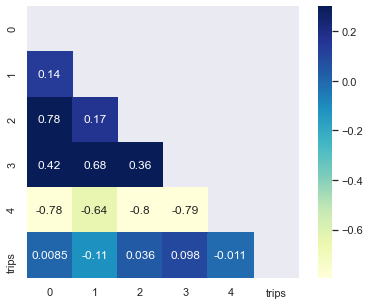

In [23]:
corr = simulation_data['pcc']
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True

labels = [i for i in range(5)]
labels.append('trips')

with sns.axes_style("dark"):
    f, ax = plt.subplots(figsize=(7, 5))
    ax = sns.heatmap(corr, cmap="YlGnBu", mask=mask, vmax=.3, square=True, annot=True, yticklabels=labels, xticklabels=labels)

Text(0.5, 1.0, 'Pearson Correlation Coeffecient')

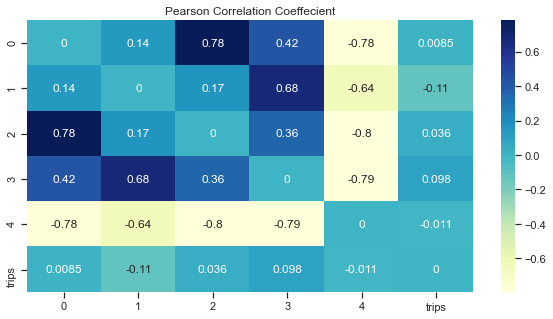

In [24]:
# temp = simulation_data['pcc']

# labels = [i for i in range(5)]
# labels.append('trips')

# plt.figure(figsize=(10,5))
# sns_plot = sns.heatmap(temp, cmap="YlGnBu", annot=True, yticklabels=labels, xticklabels=labels)

# plt.title('Pearson Correlation Coeffecient')
# # figure = sns_plot.get_figure()    
# # figure.savefig(root + folder + '/' +folder+ '_' +label+ '_transition.jpg', bbox_inches='tight', dpi=250)

### Transition Matrix

In [25]:
def caluculate_action_TM(actions):
    a = actions
    b = np.zeros((5,5), dtype='int32')

    for i in range(len(a)-1):
        b[a[i]][a[i+1]] += 1
    
    return b

In [26]:
simulation_data['action_TM'] = {}
for ant in range(1, antCount+1):
    actions_list = simulation_data['agents'][ant].loc[100000:, 'action'].tolist()
    simulation_data['action_TM'][ant] =  caluculate_action_TM(actions_list)

simulation_data['action_TM'][1]

simulation_data['action_TM']['total'] = simulation_data['action_TM'][1]
for ant in range(2, antCount+1):
    simulation_data['action_TM']['total'] = np.add(simulation_data['action_TM']['total'], simulation_data['action_TM'][ant])

Text(0.5, 1.0, 'Total')

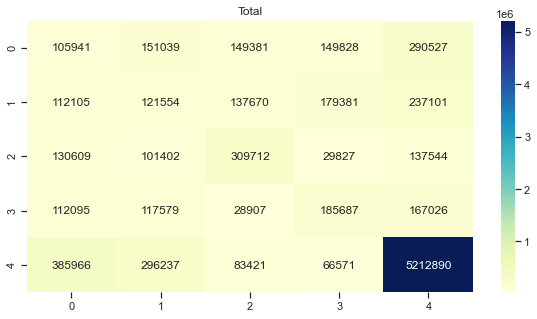

In [27]:
temp = simulation_data['action_TM']['total']

plt.figure(figsize=(10,5))
sns_plot = sns.heatmap(temp, cmap="YlGnBu", annot=True, fmt="d")

plt.title('Total')
# figure = sns_plot.get_figure()    
# figure.savefig(root + folder + '/' +folder+ '_' +label+ '_transition.jpg', bbox_inches='tight', dpi=250)

### State Action Matrix

In [28]:
def caluculate__state_action_TM(states, actions):
    a = actions
    s = states
    size = len(a)
    
    tm = np.zeros((16, 5), dtype = 'int32')
    for i in range(size):
        idx = s[i][0]*4 + s[i][1]
        tm[idx][a[i]] += 1

    return tm

In [29]:
simulation_data['state_action_TM'] = {}

for ant in range(1, antCount+1):
    actions_list = simulation_data['agents'][ant].loc[100000:, 'action'].tolist()
    states_list = simulation_data['agents'][ant].loc[100000:, 'state'].tolist()
    simulation_data['state_action_TM'][ant] =  caluculate__state_action_TM(states_list, actions_list)

simulation_data['state_action_TM'][1]

simulation_data['state_action_TM']['total'] = simulation_data['state_action_TM'][1]
for ant in range(2, antCount+1):
    simulation_data['state_action_TM']['total'] = np.add(simulation_data['state_action_TM']['total'], simulation_data['state_action_TM'][ant])

Text(0.5, 1.0, 'Total')

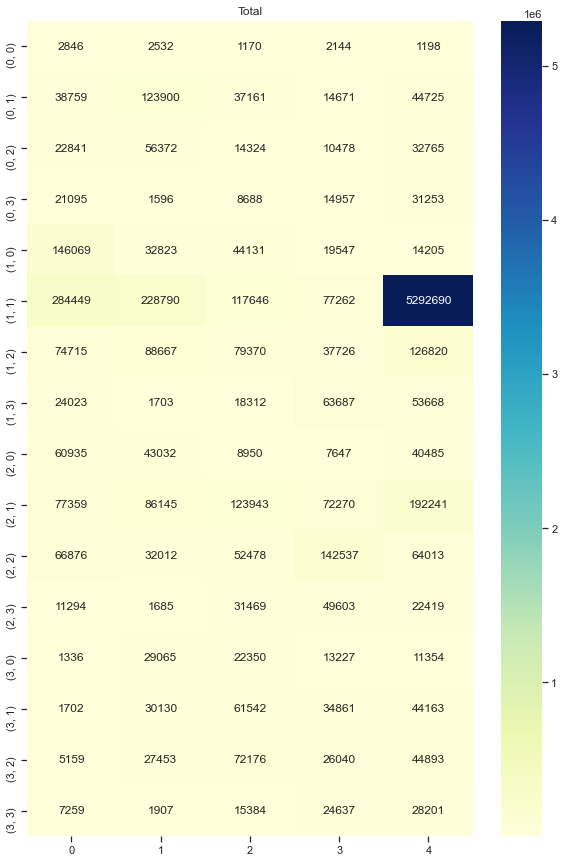

In [30]:
temp = simulation_data['state_action_TM']['total']

labels = []
for i in range(4):
    for j in range(4):
        labels.append((i,j))

plt.figure(figsize=(10,15))
sns_plot = sns.heatmap(temp, cmap="YlGnBu", annot=True, fmt="d", yticklabels=labels)

plt.title('Total')

### State Transition Matrix

In [31]:
def get_state_TM(states):
    s = states
    size = len(s)
    
    tm = np.zeros((16, 16), dtype = 'int32')
    for i in range(size-1):
        idx = s[i][0]*4 + s[i][1]
        idx_next = s[i+1][0]*4 + s[i+1][1]
        tm[idx][idx_next] += 1

    return tm

In [32]:
simulation_data['state_TM'] = {}

for ant in range(1, antCount+1):
    states_list = simulation_data['agents'][ant].loc[100000:, 'state'].tolist()
    simulation_data['state_TM'][ant] =  get_state_TM(states_list)

simulation_data['state_TM']['total'] = simulation_data['state_TM'][1]
for ant in range(2, antCount+1):
    simulation_data['state_TM']['total'] = np.add(simulation_data['state_TM']['total'], simulation_data['state_TM'][ant])

Text(0.5, 1.0, 'Total')

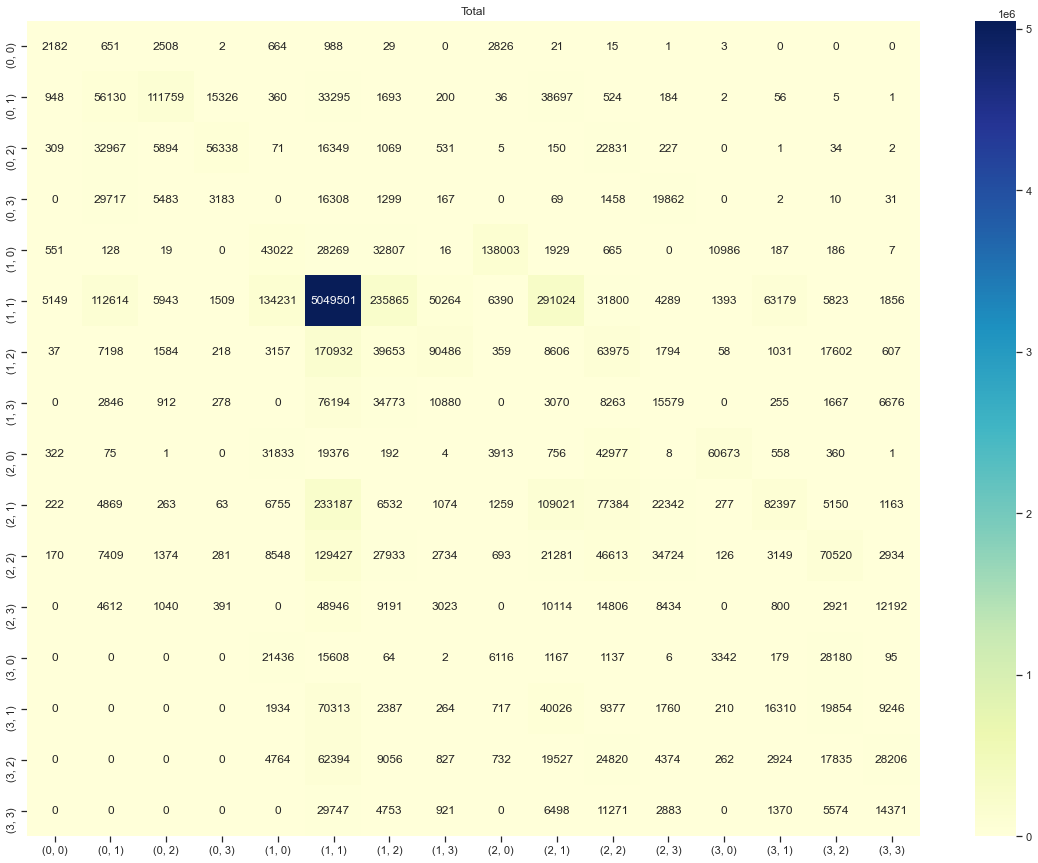

In [33]:
temp = simulation_data['state_TM']['total']

labels = []
for i in range(4):
    for j in range(4):
        labels.append((i,j))

plt.figure(figsize=(20,15))
sns_plot = sns.heatmap(temp, cmap="YlGnBu", annot=True, fmt="d", yticklabels=labels, xticklabels=labels)

plt.title('Total')